# Tutorial 2. Point aggregation

# Aggregation of Cell Towers at country level around the world

# MAP

## Introduction

In this Lesson 2, we are going to aggregate a global dataset of Cell Towers at country level. Commonly, the aggregation points to polygons is done using **Spatial Join** which is incorporated in the common python library Geopandas for spatial analysis. Geopandas has improved considerably and the aggregation runs quite fast. But, as we are exploring parallelization, we will test the library **Dask** which is designed to use the computational resources in parallel. Also, there is an integration to Geopandas which is **Dask-Geopandas** that will be used to compare the time processing with and withouth parallelization.

This exercise is designed for teaching purposes of **Spatial Data Science with High Performance Computing (HPC) at Aalto University**. Thanks to the computational resources provided by [CSC](https://www.csc.fi/) this exercises was tested in the Puhti supercomputer.

## Objective
To compare the time processing of a spatial join at global level using Geopandas and Dask-Geopandas 

## Datasets

### Cell Towers from OpenCellID
The database of Cell Towers was downloaded from [OpenCellID](https://opencellid.org/downloads.php) and stored in Allas for your availability. The compressed file is ~1 GB and decompressed ~7 GB. You will downloaded directly on your supercomputer.

### Country admin level
The country border layer was downloded from [Natural Earth](https://www.naturalearthdata.com/downloads/10m-cultural-vectors/10m-admin-0-countries/) and stored in Allas for your availability. The Geopackage file is ~4 MB.

## Output
The process will give as output the Cell Towers with country name attribute and also the country border with the aggregation value.

## HPC resources

CSC Machine-Puhti:

- *Partition*: small
- *CPU Cores*: 8
- *Memory (GB)*: 64
- *Local Disk (GB)*: 100

## Download dataset from Allas

The dataset for this practice are stored in Allas and can be downloaded to your local HPC using the next commands. Simply, run the next cells.

In [ ]:
!wget https://a3s.fi/swift/v1/AUTH_a6b8530017f34af9861fcf45a738ad3f/L2-CellTowers/L2-CellTowers-data.csv.gz

In [ ]:
!wget https://a3s.fi/swift/v1/AUTH_a6b8530017f34af9861fcf45a738ad3f/L2-CellTowers/L2-CountryAdmin-data.gpkg

# Hands-on coding
Follow the instructions and run every cell in the supercomputer.

## Importing Python libraries

Be sure that you have installed the *dask_geopandas* in your environment. Get familiar with this library reading a bit the [Dask-Geopandas Documentation](https://dask-geopandas.readthedocs.io/en/stable/)

In [45]:
import os

import dask_geopandas as geodask
import dask
import pyarrow

from dask import delayed
import geopandas as gpd
import pandas as pd

import multiprocessing as mp

import time
import matplotlib.pyplot as plt

import warnings
warnings.simplefilter("ignore")

# 1) Geopandas - 1 Core

### Read data

In [2]:
%%time

# read as loop of pandas dataframe

# ---- read in DF  
data_df = pd.read_csv('opencellid/cell_towers.csv.gz', 
                      compression='gzip'
                      )

CPU times: user 46.7 s, sys: 10 s, total: 56.7 s
Wall time: 56.9 s


In [3]:
len(data_df)/1000000

47.263882

In [4]:
data_df.head(2)

,radio,mcc,net,area,cell,unit,lon,lat,range,samples,changeable,created,updated,averageSignal
0,UMTS,262,2,801,86355,0,13.285512,52.522202,1000,7,1,1282569574,1300155341,0
1,GSM,262,2,801,1795,0,13.276907,52.525714,5716,9,1,1282569574,1300155341,0


### Create Geodataframe

In [5]:
# geodataframe
data_gdf = gpd.GeoDataFrame(data_df, 
                           geometry = gpd.points_from_xy(data_df.lon, data_df.lat),
                           crs=4326)

In [6]:
antennas_gdf = data_gdf[['lon', 'lat', 'created', 'geometry']]

In [7]:
antennas_gdf.head(2)

,lon,lat,created,geometry
0,13.285512,52.522202,1282569574,POINT (13.28551 52.52220)
1,13.276907,52.525714,1282569574,POINT (13.27691 52.52571)


## Create a source DataFrame - World countries

In [8]:
# from geopandas
countries = gpd.read_file(r'shp/world-administrative-boundaries.shp')

In [9]:
countries = countries.dropna()

countries_gdf = countries[['iso3', 'name', 'continent', 'geometry']]

countries_gdf.head()

,iso3,name,continent,geometry
0,UGA,Uganda,Africa,"POLYGON ((33.92110 -1.00194, 33.92027 -1.00111..."
1,UZB,Uzbekistan,Asia,"POLYGON ((70.97081 42.25467, 70.98054 42.26205..."
2,IRL,Ireland,Europe,"MULTIPOLYGON (((-9.97014 54.02083, -9.93833 53..."
3,ERI,Eritrea,Africa,"MULTIPOLYGON (((40.13583 15.75250, 40.12861 15..."
5,MNG,Mongolia,Asia,"POLYGON ((116.71138 49.83047, 116.64665 49.738..."


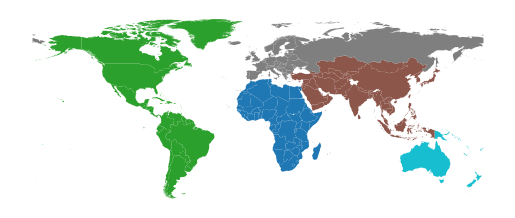

In [10]:
ax = countries_gdf.plot(column='continent', categorical=True);
ax.axis(False);

## Spatial Join

In [11]:
%%time

s1 = time.time()

# ----- S Join
antennas_gpd = gpd.sjoin(antennas_gdf, countries_gdf, 
                         predicate='within', how='inner')

# ------------------------------------------- 
time1 = time.time() - s1

CPU times: user 2min 21s, sys: 11.5 s, total: 2min 33s
Wall time: 2min 32s


In [12]:
print(f'Total duration with 1 core Geopandas {time1/60} min')

Total duration with 1 core Geopandas 2.5494649171829225 min


# 2) Dask - 16 Core

In [13]:
# antennas to Dask
all_antennas = geodask.from_geopandas(antennas_gdf, npartitions=16)

In [14]:
all_antennas.head(2)

,lon,lat,created,geometry
0,13.285512,52.522202,1282569574,POINT (13.28551 52.52220)
1,13.276907,52.525714,1282569574,POINT (13.27691 52.52571)


### Spatial join

In [15]:
%%time

s2 = time.time()

# ----- S Join
antennas_dask = geodask.sjoin(all_antennas, countries_gdf, 
                         predicate='within', how='inner').compute()

# ------------------------------------------- 
time2 = time.time() - s2

CPU times: user 1min 56s, sys: 9 s, total: 2min 5s
Wall time: 51.5 s


In [26]:
print(f'Total duration with GeoDask {time2} sec')

Total duration with GeoDask 51.538538694381714 sec


CPU times: user 1min 50s, sys: 690 ms, total: 1min 50s
Wall time: 1min 50s


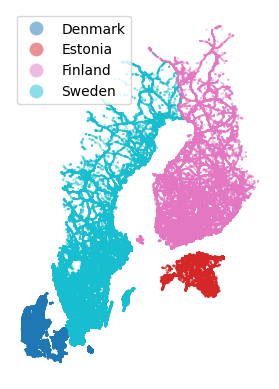

In [17]:
%%time

fig, ax = plt.subplots()

antennas_dask[antennas_dask['name'].isin(['Finland', 'Estonia', 'Sweden', 'Denmark'])].plot(ax=ax, 
                                                                     column='name', 
                                                                     categorical=True, 
                                                                     legend=True,
                                                                     markersize=0.2,
                                                                     alpha=0.5);

ax.axis(False);

In [18]:
antennas_dask.head()

,lon,lat,created,geometry,index_right,iso3,name,continent
0,13.285512,52.522202,1282569574,POINT (13.28551 52.52220),188,DEU,Germany,Europe
1,13.276907,52.525714,1282569574,POINT (13.27691 52.52571),188,DEU,Germany,Europe
2,13.285064,52.524000,1282569574,POINT (13.28506 52.52400),188,DEU,Germany,Europe
3,13.285446,52.521744,1282569574,POINT (13.28545 52.52174),188,DEU,Germany,Europe
4,13.293457,52.521515,1282569574,POINT (13.29346 52.52152),188,DEU,Germany,Europe
